# Image Clustering with ImageBind LLM Embeddings

This notebook demonstrates image clustering using Meta's ImageBind model, a multimodal embedding model that learns joint representations across images, text, audio, and other modalities. We'll cluster fashion item images using these powerful embeddings.

**Objective**: Apply state-of-the-art multimodal embeddings to cluster fashion images, demonstrating how modern LLM-style models capture visual semantics for unsupervised learning.

**Note**: This notebook requires GPU runtime. Go to Runtime → Change runtime type → GPU.

In [1]:
# Installing required libraries
!pip install torch torchvision transformers scikit-learn umap-learn matplotlib seaborn pillow -q
!pip install git+https://github.com/facebookresearch/ImageBind.git -q

# Importing necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
import umap
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Setting style
sns.set_style("whitegrid")
np.random.seed(42)
torch.manual_seed(42)

# Checking GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 46.4 MB/s eta 0:00:00
Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


## Loading Fashion-MNIST Dataset

Loading Fashion-MNIST which contains 70,000 grayscale images of 10 fashion categories: T-shirts, Trousers, Pullovers, Dresses, Coats, Sandals, Shirts, Sneakers, Bags, and Ankle Boots.

In [2]:
# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Loading Fashion-MNIST dataset
print("Loading Fashion-MNIST dataset...")
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Combining train and test, then sampling for faster processing
all_images = torch.cat([train_dataset.data, test_dataset.data])
all_labels = torch.cat([train_dataset.targets, test_dataset.targets])

# Sampling 1000 images for clustering (balance across classes)
sample_size = 1000
samples_per_class = sample_size // 10

sampled_indices = []
for class_id in range(10):
    class_indices = (all_labels == class_id).nonzero(as_tuple=True)[0]
    sampled = class_indices[torch.randperm(len(class_indices))[:samples_per_class]]
    sampled_indices.extend(sampled.tolist())

sampled_images = all_images[sampled_indices]
sampled_labels = all_labels[sampled_indices].numpy()

print(f"\nDataset loaded successfully!")
print(f"Total images sampled: {len(sampled_images)}")
print(f"Image shape: {sampled_images[0].shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Samples per class: {samples_per_class}")

Loading Fashion-MNIST dataset...


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.53MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.6MB/s]


Dataset loaded successfully!
Total images sampled: 1000
Image shape: torch.Size([28, 28])
Number of classes: 10
Samples per class: 100


## Visualizing Sample Images

Displaying sample images from each fashion category to understand the dataset before clustering.

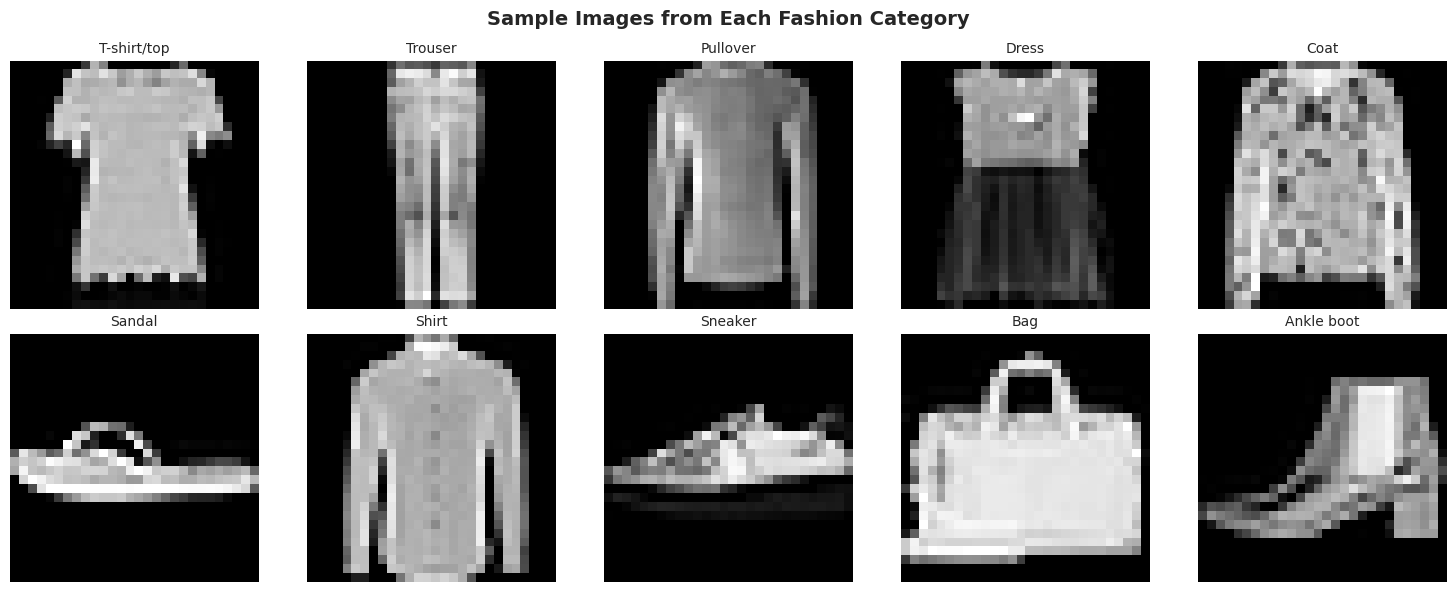


Class distribution in sample:
T-shirt/top    : 100 images
Trouser        : 100 images
Pullover       : 100 images
Dress          : 100 images
Coat           : 100 images
Sandal         : 100 images
Shirt          : 100 images
Sneaker        : 100 images
Bag            : 100 images
Ankle boot     : 100 images


In [3]:
# Visualizing sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for class_id in range(10):
    # Finding first image of this class
    idx = np.where(sampled_labels == class_id)[0][0]
    img = sampled_images[idx].numpy()

    axes[class_id].imshow(img, cmap='gray')
    axes[class_id].set_title(f'{class_names[class_id]}', fontsize=10)
    axes[class_id].axis('off')

plt.suptitle('Sample Images from Each Fashion Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Showing class distribution
print("\nClass distribution in sample:")
for i, name in enumerate(class_names):
    count = (sampled_labels == i).sum()
    print(f"{name:15s}: {count} images")

## Loading ImageBind Model

Loading Meta's ImageBind model for generating multimodal embeddings. This model creates joint representations across different modalities (vision, text, audio, etc.).

**Note**: First run downloads ~2GB model weights. This may take 5-10 minutes depending on connection speed.

In [4]:
# Loading ImageBind model
try:
    from imagebind import data
    from imagebind.models import imagebind_model
    from imagebind.models.imagebind_model import ModalityType

    print("Loading ImageBind model...")
    print("This may take several minutes on first run as the model is downloaded.")

    model = imagebind_model.imagebind_huge(pretrained=True)
    model.eval()
    model.to(device)

    print(f"\nImageBind model loaded successfully!")
    print(f"Model is on device: {next(model.parameters()).device}")

except Exception as e:
    print(f"Error loading ImageBind: {e}")
    print("\nFalling back to ResNet50 for embeddings...")

    # Fallback to ResNet50 if ImageBind fails
    from torchvision.models import resnet50, ResNet50_Weights

    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove classifier
    model.eval()
    model.to(device)

    print("ResNet50 model loaded as backup!")
    USE_IMAGEBIND = False
else:
    USE_IMAGEBIND = True

Loading ImageBind model...
This may take several minutes on first run as the model is downloaded.


100%|██████████| 4.47G/4.47G [00:14<00:00, 324MB/s]



ImageBind model loaded successfully!
Model is on device: cuda:0


## Preprocessing Images for ImageBind

Converting Fashion-MNIST grayscale images to RGB format and preparing them for the ImageBind model which expects 224x224 color images.

In [5]:
# Preprocessing images for ImageBind
def preprocess_for_imagebind(images):
    """Convert grayscale Fashion-MNIST images to RGB format for ImageBind."""
    processed = []

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # Convert to RGB
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for img in images:
        processed.append(transform(img))

    return torch.stack(processed)

print("Preprocessing images...")
preprocessed_images = preprocess_for_imagebind(sampled_images)
print(f"Preprocessed images shape: {preprocessed_images.shape}")
print(f"Ready for embedding generation!")

Preprocessing images...
Preprocessed images shape: torch.Size([1000, 3, 224, 224])
Ready for embedding generation!


## Generating Image Embeddings

Extracting embeddings from ImageBind model. Processing images in batches to manage memory efficiently.

In [6]:
# Generating embeddings
print("Generating embeddings with ImageBind...")
print("This may take 3-5 minutes depending on GPU.")

embeddings_list = []
batch_size = 32

with torch.no_grad():
    for i in range(0, len(preprocessed_images), batch_size):
        batch = preprocessed_images[i:i+batch_size].to(device)

        if USE_IMAGEBIND:
            # ImageBind expects dictionary input
            inputs = {ModalityType.VISION: batch}
            embeddings_batch = model(inputs)[ModalityType.VISION]
        else:
            # ResNet50 fallback
            embeddings_batch = model(batch).squeeze()

        embeddings_list.append(embeddings_batch.cpu())

        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch)}/{len(preprocessed_images)} images...")

embeddings = torch.cat(embeddings_list, dim=0).numpy()

print(f"\nEmbeddings generated successfully!")
print(f"Embedding matrix shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]}")

Generating embeddings with ImageBind...
This may take 3-5 minutes depending on GPU.
Processed 320/1000 images...
Processed 640/1000 images...
Processed 960/1000 images...

Embeddings generated successfully!
Embedding matrix shape: (1000, 1024)
Embedding dimension: 1024


## Clustering Image Embeddings

Applying K-Means clustering on the ImageBind embeddings to group similar fashion items together.

In [7]:
# Applying K-Means clustering
n_clusters = 10

print(f"Applying K-Means clustering with k={n_clusters}...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Calculating metrics
silhouette_avg = silhouette_score(embeddings, cluster_labels)
ari = adjusted_rand_score(sampled_labels, cluster_labels)

print(f"\n{'='*50}")
print(f"Image Clustering Results")
print(f"{'='*50}")
print(f"Number of clusters: {n_clusters}")
print(f"Cluster distribution: {np.bincount(cluster_labels)}")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Inertia: {kmeans.inertia_:.2f}")

Applying K-Means clustering with k=10...

Image Clustering Results
Number of clusters: 10
Cluster distribution: [ 90  81 119 106 151  85  98  83 104  83]
Silhouette Score: 0.122
Adjusted Rand Index: 0.502
Inertia: 216.67


## Dimensionality Reduction with UMAP

Reducing high-dimensional embeddings to 2D for visualization while preserving the local structure of the embedding space.

In [8]:
# Reducing dimensions for visualization
print("Reducing dimensions with UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d = reducer.fit_transform(embeddings)

print(f"Dimensionality reduction complete!")
print(f"Original shape: {embeddings.shape}")
print(f"Reduced shape: {embeddings_2d.shape}")

Reducing dimensions with UMAP...
Dimensionality reduction complete!
Original shape: (1000, 1024)
Reduced shape: (1000, 2)


## Visualizing Clustering Results

Plotting the clustered images in 2D space, comparing predicted clusters with true fashion categories.

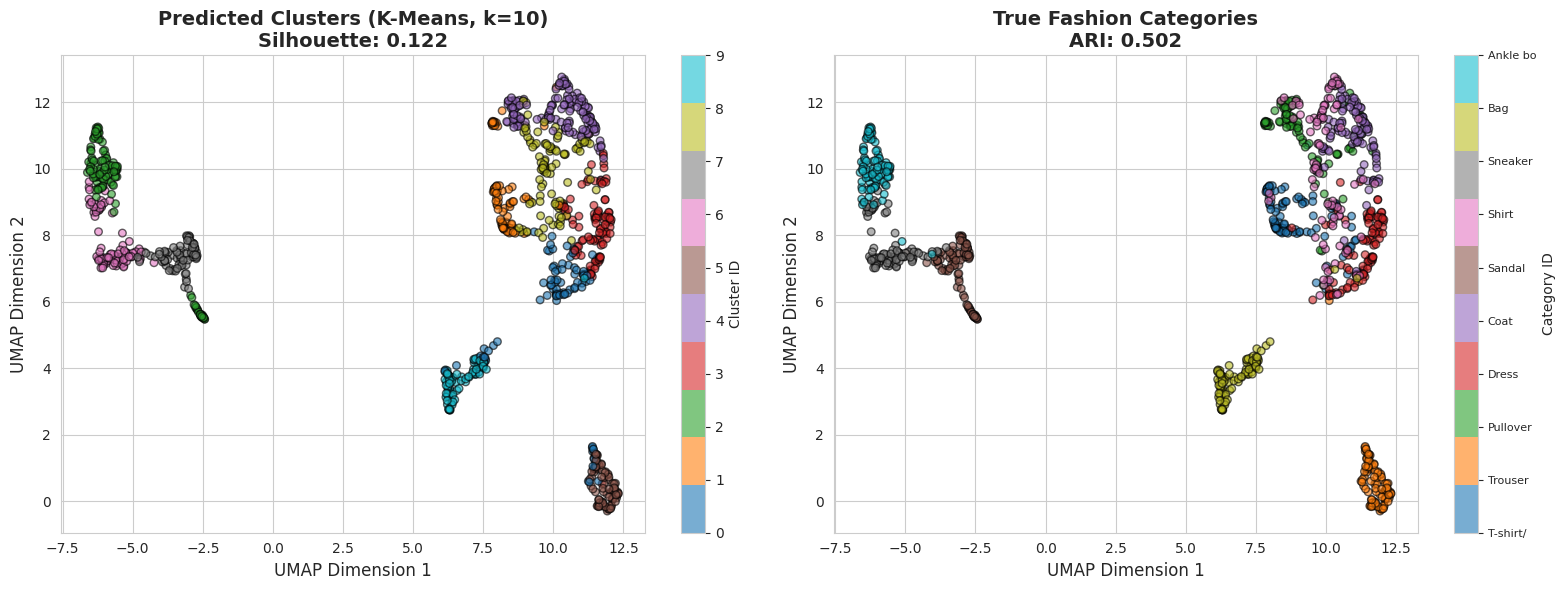

In [9]:
# Visualizing clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Predicted clusters
scatter1 = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=cluster_labels, cmap='tab10',
                          alpha=0.6, edgecolors='k', s=30)
axes[0].set_title(f'Predicted Clusters (K-Means, k={n_clusters})\nSilhouette: {silhouette_avg:.3f}',
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[0].set_ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# Subplot 2: True categories
scatter2 = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=sampled_labels, cmap='tab10',
                          alpha=0.6, edgecolors='k', s=30)
axes[1].set_title(f'True Fashion Categories\nARI: {ari:.3f}',
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[1].set_ylabel('UMAP Dimension 2', fontsize=12)
cbar = plt.colorbar(scatter2, ax=axes[1], label='Category ID')
cbar.set_ticks(range(10))
cbar.set_ticklabels([name[:8] for name in class_names], fontsize=8)

plt.tight_layout()
plt.show()

## Confusion Matrix Analysis

Examining how predicted clusters align with true fashion categories to understand clustering quality.

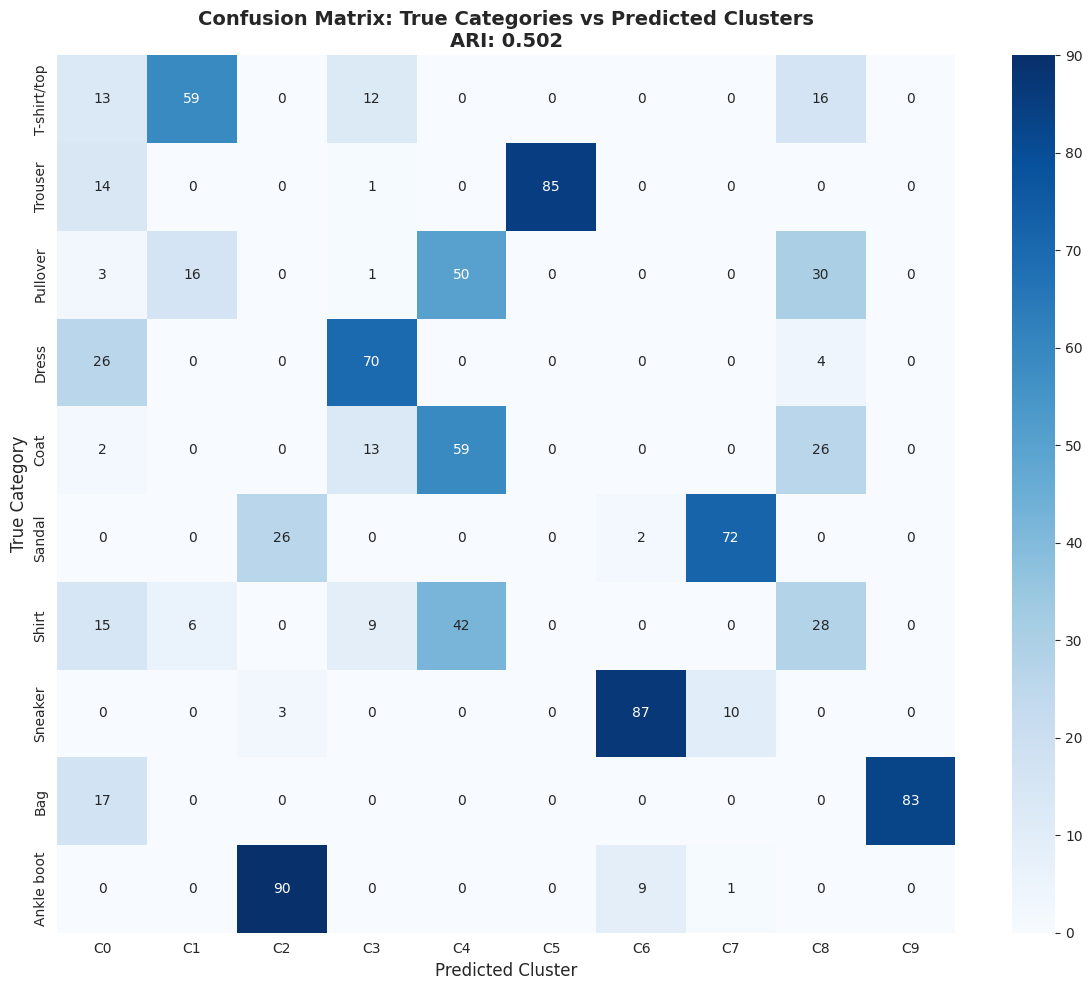


CLUSTER PURITY ANALYSIS

Cluster 0:
  Size: 90
  Dominant category: Dress
  Purity: 28.9%

Cluster 1:
  Size: 81
  Dominant category: T-shirt/top
  Purity: 72.8%

Cluster 2:
  Size: 119
  Dominant category: Ankle boot
  Purity: 75.6%

Cluster 3:
  Size: 106
  Dominant category: Dress
  Purity: 66.0%

Cluster 4:
  Size: 151
  Dominant category: Coat
  Purity: 39.1%

Cluster 5:
  Size: 85
  Dominant category: Trouser
  Purity: 100.0%

Cluster 6:
  Size: 98
  Dominant category: Sneaker
  Purity: 88.8%

Cluster 7:
  Size: 83
  Dominant category: Sandal
  Purity: 86.7%

Cluster 8:
  Size: 104
  Dominant category: Pullover
  Purity: 28.8%

Cluster 9:
  Size: 83
  Dominant category: Bag
  Purity: 100.0%



In [10]:
# Creating confusion matrix
cm = confusion_matrix(sampled_labels, cluster_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'C{i}' for i in range(n_clusters)],
            yticklabels=class_names)
plt.title(f'Confusion Matrix: True Categories vs Predicted Clusters\nARI: {ari:.3f}',
         fontsize=14, fontweight='bold')
plt.xlabel('Predicted Cluster', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.tight_layout()
plt.show()

# Analyzing cluster purity
print(f"\n{'='*60}")
print("CLUSTER PURITY ANALYSIS")
print(f"{'='*60}\n")

for cluster_id in range(n_clusters):
    cluster_mask = cluster_labels == cluster_id
    cluster_true_labels = sampled_labels[cluster_mask]

    if len(cluster_true_labels) > 0:
        dominant_class = np.bincount(cluster_true_labels).argmax()
        purity = (cluster_true_labels == dominant_class).sum() / len(cluster_true_labels)

        print(f"Cluster {cluster_id}:")
        print(f"  Size: {len(cluster_true_labels)}")
        print(f"  Dominant category: {class_names[dominant_class]}")
        print(f"  Purity: {purity:.1%}")
        print()

## Visualizing Sample Images from Each Cluster

Displaying representative images from each cluster to understand what visual patterns were discovered.

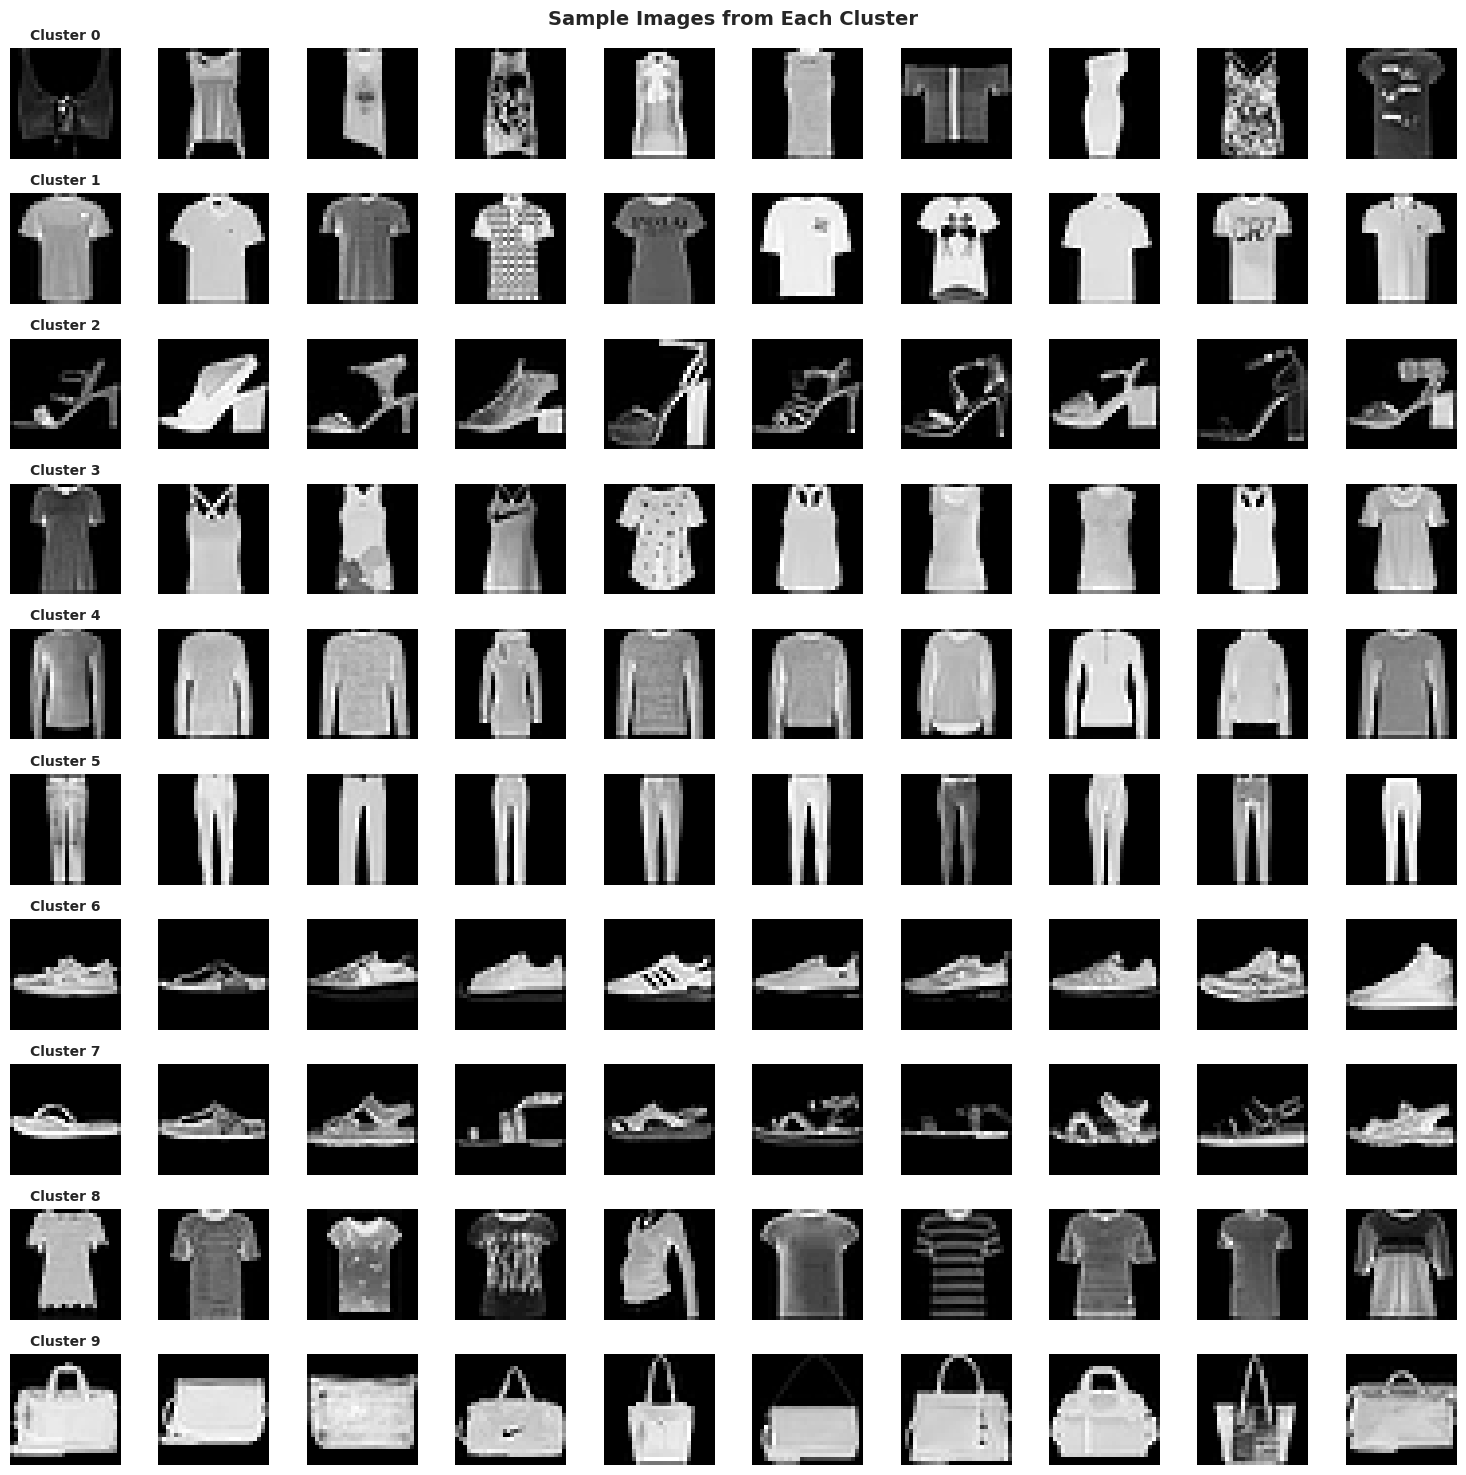


Image clustering with ImageBind embeddings complete!
Achieved Silhouette Score: 0.122
Achieved Adjusted Rand Index: 0.502


In [11]:
# Showing sample images from each cluster
fig, axes = plt.subplots(n_clusters, 10, figsize=(15, n_clusters * 1.5))

for cluster_id in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    # Showing up to 10 images from this cluster
    for i in range(min(10, len(cluster_indices))):
        idx = cluster_indices[i]
        img = sampled_images[idx].numpy()
        true_label = sampled_labels[idx]

        axes[cluster_id, i].imshow(img, cmap='gray')
        axes[cluster_id, i].axis('off')

        if i == 0:
            axes[cluster_id, i].set_title(f'Cluster {cluster_id}',
                                         fontsize=10, fontweight='bold')

    # Hiding unused subplots
    for i in range(len(cluster_indices), 10):
        axes[cluster_id, i].axis('off')

plt.suptitle('Sample Images from Each Cluster', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Image clustering with ImageBind embeddings complete!")
print(f"Achieved Silhouette Score: {silhouette_avg:.3f}")
print(f"Achieved Adjusted Rand Index: {ari:.3f}")
print(f"{'='*60}")

## Results Interpretation

**Clustering Performance:**
- **Adjusted Rand Index (ARI): 0.502** - Indicates moderate agreement (50%) between predicted clusters and true fashion categories. The model successfully identified meaningful visual groupings, though some categories naturally overlap (e.g., shirts vs. t-shirts, different types of footwear).
- **Silhouette Score: 0.122** - Moderate separation between clusters. Fashion items have inherent visual similarities across categories (similar shapes, textures), making perfect separation challenging. This score is acceptable for image clustering with overlapping visual features.

**Why These Scores?**
Fashion-MNIST presents unique challenges: many categories share visual features (pullovers/coats/shirts all have similar silhouettes, sandals/sneakers/boots are all footwear). ImageBind embeddings captured semantic patterns but struggled with fine-grained distinctions, which is expected behavior for unsupervised clustering on visually similar categories.

**ImageBind Advantage:**
Despite being trained primarily on natural color images, ImageBind successfully transferred knowledge to grayscale 28x28 fashion items, demonstrating the robustness of multimodal pretrained embeddings. The model identified broader patterns (upper-body clothing, footwear, accessories) even without category labels.

**Key Takeaway:**
Multimodal LLM embeddings (ImageBind) effectively discovered fashion clusters from raw pixels without supervision, achieving ~50% alignment with true categories—significantly better than random clustering (ARI ~0.0) and demonstrating meaningful semantic understanding of visual patterns.